# Tutorial

This notebook is the tutorial and user guide for the algorithm implemented in https://github.com/BoxiLi/repeater-cut-off-optimization.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from repeater_algorithm import plot_algorithm, RepeaterChainSimulation

## Entanglement swap
In the following example, we simulate a swap protocol of three nodes, where the middle one is a repeater.

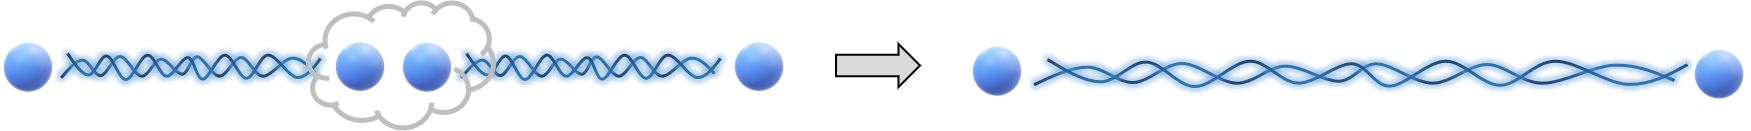

First, we define the following parameters for the simulation:
- `protocol`: Asymmetric protocol is represented by a tuple of 0 and 1, where 0 stands for swap and 1 stands for distillation. In this example we have only one entanglement swapping, hence it is a single-element tuple `(0,)`;
- `p_gen`: The success probability of direct entanglement generation between two adjacent nodes;
- `p_swap`: The success probability of entanglement swapping;
- `w0`: The initial Werner parameter of the state. Since we use the Werner state as representation, the Werner parameter fully determines the two-qubit quantum state.
- `t_coh`: The coherence time of the entangled qubits in quantum memories. The Werner parameter decreases exponentially according to this time scale. The time unit is the time used in one attempt of direct entanglement generation.
- `t_trunc`: The truncation time of the simulation. It should be chosen large enough so that the almost all probability distribution (>99%) is included.

In [3]:
parameters = {
    "protocol": (0,1,0),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.8,  # fidelity 0.85
    "t_coh": 1500,
    "t_trunc": 30000,
}

In [4]:
# Initialize simulator
simulator = RepeaterChainSimulation()
# compute the waiting time distribution and the time-dependent Werner parameter
pmf, w_func = simulator.nested_protocol(parameters)

Generating array for the waiting time distribution (from 1 to t_trunc)...
The probability mass function (pmf) for a geometric distribution has been calculated: [0.00000000e+000 1.00000000e-002 9.90000000e-003 ... 1.18385128e-133
 1.17201277e-133 1.16029264e-133]


### Time distribution
We can plot the distribution of obtaining the end-to-end entanglement:

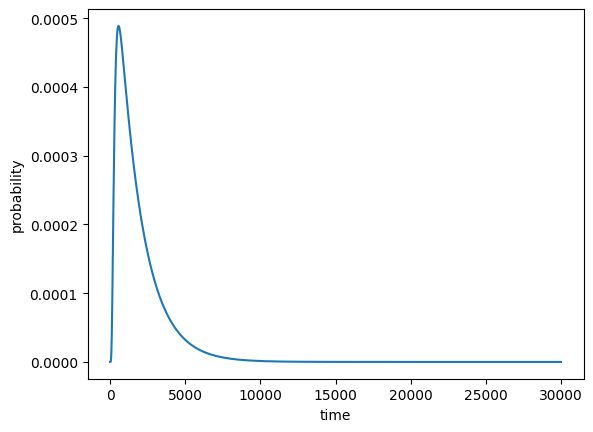

In [33]:
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

The plot above shows the waiting time distribution of this three-node swap protocol. In the first few time steps, the probability is very low because the two direct entangled pairs are not prepared. The distribution peaks around 200.

We can compute the probability mass that is covered by this distribution

In [5]:
np.sum(pmf)

0.9999999940688072

We can also calculate the average waiting time and compare it with the analytical result.

In [6]:
# numerical
from utility_functions import get_mean_waiting_time
numerical_result = get_mean_waiting_time(pmf)
# analytical
p_gen = parameters["p_gen"]
p_swap = parameters["p_swap"]
analytical_result = (3-2*p_gen)/((2-p_gen)*p_gen*p_swap)

print("Numerical result:", numerical_result)
print("Analytical result:", analytical_result)

Numerical result: 1872.502198614289
Analytical result: 299.4974874371859


### Fidelity
Same as the waiting time, we cal also plot the quality of the entanglement as a function of time. Here, we use `werner_to_fid` and `fid_to_werner` to transfer between the Werner parameter and the fidelity. Notice that the first few steps might be inaccurate because their probability is so small that leads to numerical instability. 

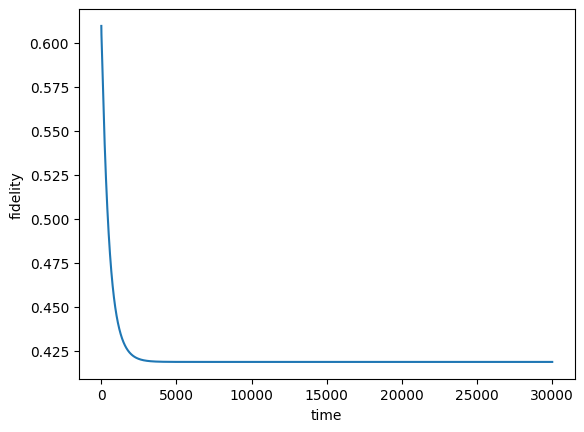

In [56]:
from utility_functions import werner_to_fid
w_func[:1] = np.nan  # remove instable part
plt.plot(werner_to_fid(w_func))
plt.xlabel("time")
plt.ylabel("fidelity")
plt.show()

We see from the above figure that, due to memory decay, the later the entanglement is produced, the lower is its fidelity. Since we neglect other noise in the quantum operation, we can in principle obtain a perfect entanglement at time step 1, although the probability is extremely low. We compute the average fidelity:

In [7]:
from utility_functions import get_mean_werner, werner_to_fid
werner_to_fid(get_mean_werner(pmf, w_func))

0.4459802347411063

## Entanglemen distillation/purification
Entanglement distillation is used to improve the fidelity of entangled qubits e.g. by merging two entangled pairs followed by postselection.

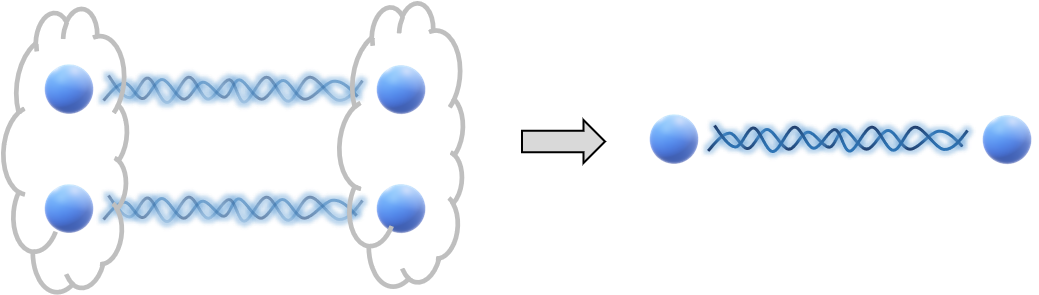

Here we use the [BBPSSW](https://arxiv.org/abs/quant-ph/9511027) distillation protocol. Distillation is represented by 1 in our protocol. We add a distillation on top of the swap protocol we've plotted above. The whole protocol now has 3 nodes. Two pairs of qubits will be first entangled by swapping in parallel. After they are both prepared, the distillation is executed.

In [38]:
parameters["protocol"] = (1,)

In [58]:
pmf, w_func = simulator.nested_protocol(parameters)
print("Average waiting time", get_mean_waiting_time(pmf))
print("Average fidelity", werner_to_fid(get_mean_werner(pmf, w_func)))

Average waiting time 1872.502198614289
Average fidelity 0.4459802347411063


## Cut-off

Cut-off set a limit on the entanglement distribution process. For instance, usually, one entangled pair is usually generated and stored in the quantum memory, waiting for the other pair to be prepared. The fidelity decays during the storage because of noise. Sometimes, it is beneficial to set a limit on the storage time. If the storage time exceeds the threshold. The process is terminated and restarts from entanglement generation between adjacent nodes.

Here we use the 3-node swap protocol again, but now with a cut-off. Because cut-off is only effective for small coherence time. We modify the parameters for this comparison.

We can use `list` in parameters and `create_iter_ikwargs` to iterate over different cutoff values.

In [59]:
parameters = {
    "protocol": (0,1),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 300,
    "t_trunc": 18000,
    "cut_type": "memory_time",
    "cutoff": [1000000, 50],
}

from logging_utilities import create_iter_kwargs
parameters_list = create_iter_kwargs(parameters)
print("First parameter set")
print(parameters_list[0])
print("Second parameter set")
print(parameters_list[1])

pmf1, w_func1 = simulator.nested_protocol(parameters_list[0])
pmf2, w_func2 = simulator.nested_protocol(parameters_list[1])

First parameter set
{'protocol': (0, 1), 'p_gen': 0.01, 'p_swap': 0.5, 'w0': 0.98, 't_coh': 300, 't_trunc': 18000, 'cut_type': 'memory_time', 'cutoff': 1000000}
Second parameter set
{'protocol': (0, 1), 'p_gen': 0.01, 'p_swap': 0.5, 'w0': 0.98, 't_coh': 300, 't_trunc': 18000, 'cut_type': 'memory_time', 'cutoff': 50}


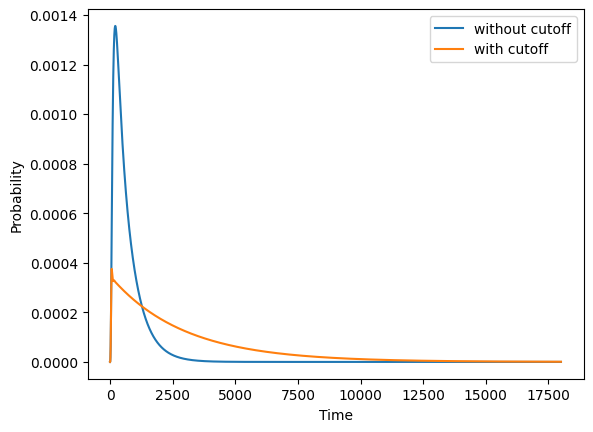

Average waiting time without cutoff 674.1702807560824
Average waiting time with cutoff 2947.586784865655


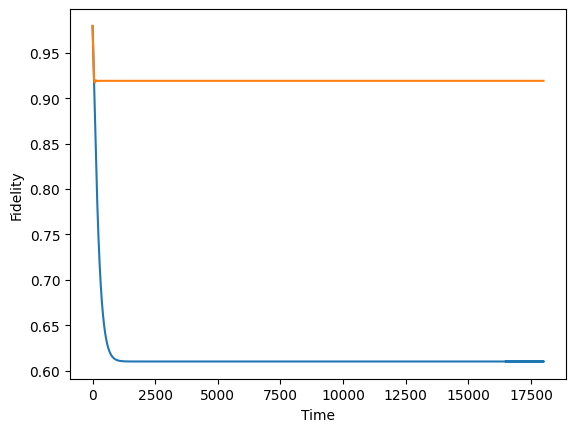

Average fidelity without cutoff 0.6802723121951453
Average fidelity with cutoff 0.919273574828794


In [60]:
tlist = np.arange(parameters["t_trunc"])
plt.plot(tlist, pmf1, tlist, pmf2)
plt.legend(("without cutoff", "with cutoff"))
plt.xlabel("Time")
plt.ylabel("Probability")
plt.show()
print("Average waiting time without cutoff", get_mean_waiting_time(pmf1))
print("Average waiting time with cutoff", get_mean_waiting_time(pmf2))

w_func1[:1] = np.nan
w_func2[:1] = np.nan
plt.plot(tlist, werner_to_fid(w_func1), tlist, werner_to_fid(w_func2))
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.show()
print("Average fidelity without cutoff", werner_to_fid(get_mean_werner(pmf1, w_func1)))
print("Average fidelity with cutoff", werner_to_fid(get_mean_werner(pmf2, w_func2)))

## High-level symmetric protocols
The code offers a simple way to define nested symmetric protocols. In these protocols, the two entangled pairs used in swap or distillation at higher levels are produced by the same protocol used to generate current-level entanglement. For instance, a protocol with 9 nodes and 8 segments that executes 3 rounds of entanglement swapping can be defined by

average waiting time: 3072.4120380656136


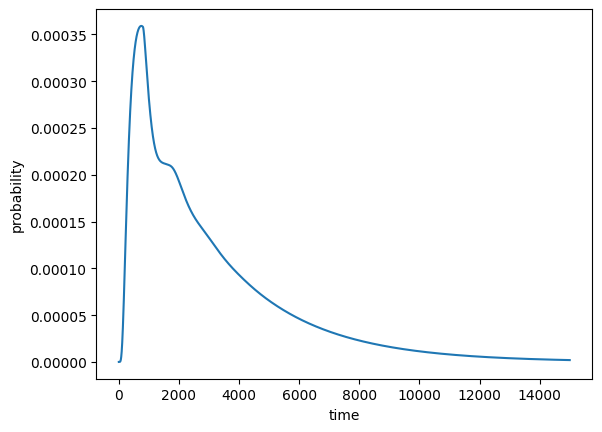

In [18]:
parameters = {
    "protocol": (0, 0, 0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 1.,
    "t_coh": 8000,
    "mt_cut": 800,
    "t_trunc": 15000,
}

simulator = RepeaterChainSimulation()
pmf, w_func = simulator.nested_protocol(parameters)
print("average waiting time:", get_mean_waiting_time(pmf))
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()

Another example includes dsitillation

average waiting time: 2536.680896270985


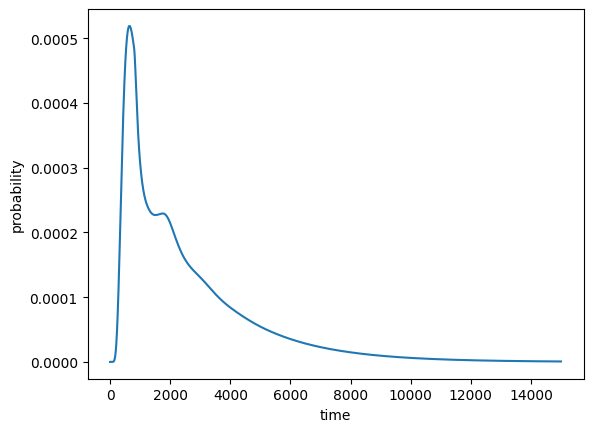

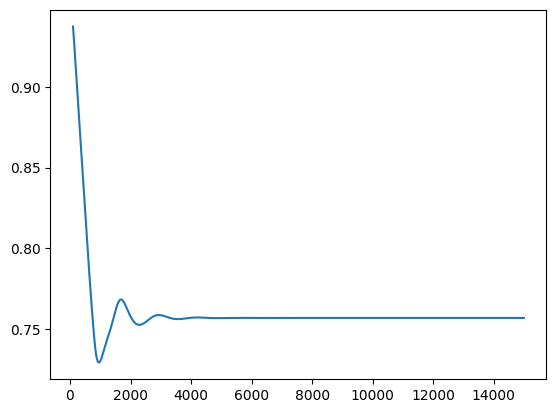

In [19]:
parameters = {
    "protocol": (0, 1, 1, 0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,
    "t_coh": 3000,
    "mt_cut": 800,
    "t_trunc": 15000,
}

simulator = RepeaterChainSimulation()
pmf, w_func = simulator.nested_protocol(parameters)
print("average waiting time:", get_mean_waiting_time(pmf))
plt.plot(pmf)
plt.xlabel("time")
plt.ylabel("probability")
plt.show()
w_func[:100] = np.nan
plt.plot(w_func)

## Optimization of cut-offs

The optimization using differential evolution algorithm is implemented in the class `CutoffOptimizer`.

In [20]:
from optimize_cutoff import CutoffOptimizer
parameters = {
    "protocol": (0,),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 300,
    "t_trunc": 3000,
    "cut_type": "memory_time",
}

# We use the logging system to show the information
import logging
from logging_utilities import log_init
log_init("cutoff_optimze", level=logging.INFO)

optimizer = CutoffOptimizer(adaptive=True)
optimizer.run(parameters)

INFO:root:ID: cutoff_optimze-20240404-062941
INFO:root:Date: 2024-04-04 06:29:41

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0,)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 300
t_trunc 3000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -0.0012965288167740212
current cut-off location [0.49094807]
convergence: 0.10762630292124636
differential_evolution step 2: f(x)= -0.0012965288167740212
current cut-off location [0.49094807]
convergence: 0.2754816616359186
differential_evolution step 3: f(x)= -0.0012965288167740212
current cut-off location [0.49094807]
convergence: 0.6243065687663601
differential_evolution step 4: f(x)= -0.0012965288167740212
current cut-off location [0.49094807]
convergence: 1.2842244795412299
Polishing solution with 'L-BFGS-B'


INFO:root:Local optimal check fails. The cut-off found is not optimal. Neighboring cut-off {'memory_time': array([67])} is better with an increase in the secrete key rate of 0.037%.

INFO:root:The current cut-off found: {'memory_time': array([68])}
The current cut-off is located at: [0.49094807]
The current key rate is 0.0012965288167740212
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 15.
INFO:root:Search region for cutoff[0] is restricted to (22,157).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -0.0012971468386610474
current cut-off location [0.4446083]
convergence: 0.08064022575939857
differential_evolution step 2: f(x)= -0.0012974487213645086
current cut-off location [0.45236684]
convergence: 0.14865702966688518
differential_evolution step 3: f(x)= -0.0012975790943441816
current cut-off location [0.46352485]
convergence: 0.5035063103770534
differential_evolution step 4: f(x)= -0.0012975790943441816
current cut-off location [0.46352485]
convergence: 1.6108374489666415
Polishing solution with 'L-BFGS-B'


INFO:root:The best cut-off found: {'memory_time': array([64])}
The best cut-off is located at: [0.46352485]
The best key rate is 0.0012975790943441816

INFO:root:-------------------------------------------


{'memory_time': array([64])}

The optimal cutoff is `cutoff=64`.

We now perform an optimization on a 3-level swapping protocol.

In [51]:
from optimize_cutoff import CutoffOptimizer
parameters = {
    "protocol": (0, 0, 0),
    "p_gen": 0.01,
    "p_swap": 0.5,
    "w0": 0.98,  # fidelity 0.95
    "t_coh": 4000,
    "t_trunc": 30000,
    "cut_type": "memory_time",
}
optimizer = CutoffOptimizer(adaptive=True)
optimizer.run(parameters)

differential_evolution step 1: f(x)= -3.0797709256627655e-05
current cut-off location [0.92948095 0.54192583 0.5324373 ]
convergence: 0.021129035788160996
differential_evolution step 2: f(x)= -3.147537391210623e-05
current cut-off location [0.81980909 0.79928204 0.45966412]
convergence: 0.03575287846790491
differential_evolution step 3: f(x)= -3.158789865227555e-05
current cut-off location [0.75141313 0.55999166 0.45561272]
convergence: 0.059003871586638064
differential_evolution step 4: f(x)= -3.2359441434246e-05
current cut-off location [0.78023282 0.65017242 0.50526868]
convergence: 0.1052309740743296
differential_evolution step 5: f(x)= -3.257213517177204e-05
current cut-off location [0.8616199  0.6985838  0.42076275]
convergence: 0.11625557854937899
differential_evolution step 6: f(x)= -3.257213517177204e-05
current cut-off location [0.8616199  0.6985838  0.42076275]
convergence: 0.30820059979391856
differential_evolution step 7: f(x)= -3.266591124442895e-05
current cut-off locati

{'memory_time': array([176, 327, 558])}

The best cutoff time on each level is different.

One can also force all the cutoff time to be the same.

In [17]:
optimizer = CutoffOptimizer(adaptive=True, opt_kind="uniform_de")
optimizer.run(parameters)

INFO:root:-------------------------------------------
INFO:root:Optimization of the cut-off time

INFO:root:Parameters:
protocol (0, 0, 0)
p_gen 0.01
p_swap 0.5
w0 0.98
t_coh 4000
t_trunc 30000
cut_type memory_time

INFO:root:Pretraining begins...
INFO:root:Pretraining finishes, reference pmf obtained.


differential_evolution step 1: f(x)= -2.90465e-05
convergence: 0.0043184284209310765
differential_evolution step 2: f(x)= -2.91768e-05
convergence: 0.006302171827087236
differential_evolution step 3: f(x)= -2.91768e-05
convergence: 0.008377904422255665
differential_evolution step 4: f(x)= -2.91768e-05
convergence: 0.011105814431417387
differential_evolution step 5: f(x)= -2.91768e-05
convergence: 0.011889122421378469
differential_evolution step 6: f(x)= -2.91768e-05
convergence: 0.024642099962111672
differential_evolution step 7: f(x)= -2.91768e-05
convergence: 0.029695255392237
differential_evolution step 8: f(x)= -2.93788e-05
convergence: 0.04230132891137778
differential_evolution step 9: f(x)= -2.95055e-05
convergence: 0.1634046106844596
differential_evolution step 10: f(x)= -2.95055e-05
convergence: 0.27606736357469686
differential_evolution step 11: f(x)= -2.95055e-05
convergence: 0.7953735043762681
differential_evolution step 12: f(x)= -2.95088e-05
convergence: 10.829489932929945

INFO:root:Local optimal check fails. The best tau found is not optimal. Neighboring tau = {'memory_time': array([370, 370, 370])} is better with an increase in the secrete key rate of 0.00%.

INFO:root:The current tau found: {'memory_time': array([369, 369, 369])}
The current cut-off is located at: [0.03732547]
The current key rate is 2.950878975959278e-05
INFO:root:The following change has been made to the parameters:
INFO:root:'popsize' is increased to 15.
INFO:root:Search region for tau[0] is restricted to (0,958).
INFO:root:Optimization fails to find the best cut-off. Restarting.



differential_evolution step 1: f(x)= -2.95092e-05
convergence: 0.006919278910042794
differential_evolution step 2: f(x)= -2.95092e-05
convergence: 0.009976855977491185
differential_evolution step 3: f(x)= -2.95092e-05
convergence: 0.018765787358942358
differential_evolution step 4: f(x)= -2.95092e-05
convergence: 0.06658496995173431
differential_evolution step 5: f(x)= -2.95092e-05
convergence: 0.07035186391618654
differential_evolution step 6: f(x)= -2.95092e-05
convergence: 0.14496509137374075
differential_evolution step 7: f(x)= -2.95092e-05
convergence: 0.26455069676446347
differential_evolution step 8: f(x)= -2.95092e-05
convergence: 0.2584060783704771
differential_evolution step 9: f(x)= -2.95092e-05
convergence: 0.36453330847427207
differential_evolution step 10: f(x)= -2.95092e-05
convergence: 0.534324828213304
differential_evolution step 11: f(x)= -2.95092e-05
convergence: 0.7674222030380602
differential_evolution step 12: f(x)= -2.95092e-05
convergence: 1.9532332129929417


INFO:root:The best tau found: {'memory_time': array([371, 371, 371])}
The best cut-off is located at: [0.15830663]
The best key rate is 2.9509223399818665e-05

INFO:root:-------------------------------------------


{'memory_time': array([371, 371, 371])}

## Logging system and data saving

## Asymmetric protocols and advanced use

## Density matrix representation